In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from Bio import SeqIO
import csv
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"
import itertools
bamFilePath_1 = "data/RealData/merged_HST_Fumane_50_50_100reads.bam"
bamFilePath_2 = "data/RealData/merged_NeaDenisovaCave_Fumane_50_50_100reads.bam"

def findsubsets(s, n):
    subsets = list(itertools.combinations(s, n))
    return [list(a) for a in subsets]

def getListOfReadsFromBamFile(bamFilePath):
    samfile = pysam.AlignmentFile(bamFilePath, "rb")
    list_to_return = []
    for entry in samfile:
        list_to_return.append({
            "read": str(entry.seq),
            "isReverse": entry.is_reverse,
            "name": entry.to_dict()["name"]
        })
    return list_to_return

2023-09-23 13:36:21.875379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 13:36:22.481414: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-23 13:36:22.712988: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-23 13:36:24.510854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

## Start with the first dataset

In [3]:
sequences_1 = getListOfReadsFromBamFile(bamFilePath_1)
sorted_reads_1 = sorted(sequences_1, key=lambda a: a["name"])
sorted_reads_only_sequence_1 = [a["read"] for a in sorted_reads_1]

[E::idx_find_and_load] Could not retrieve index file for 'data/RealData/merged_HST_Fumane_50_50_100reads.bam'


In [4]:
maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(sorted_reads_only_sequence_1,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  100
start working on read number 0
start working on read number 40
start working on read number 80


In [6]:
maximum_likelihood_calculator_d_1.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.8,0.175,0.025


### Calculate shap with 10000 samples

In [10]:
shaps_10000_dataset_1 = maximum_likelihood_calculator_d_1.calculate_shapley_values(10000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10000


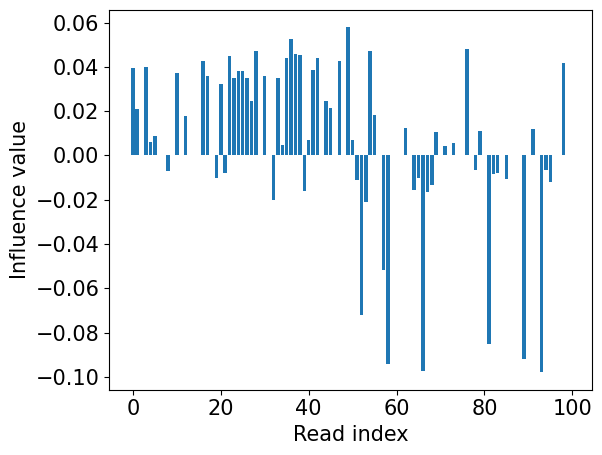

In [13]:
plt.bar([i for i in range(100)],shaps_10000_dataset_1[0][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_1_shap_homosapiens.png", bbox_inches='tight')



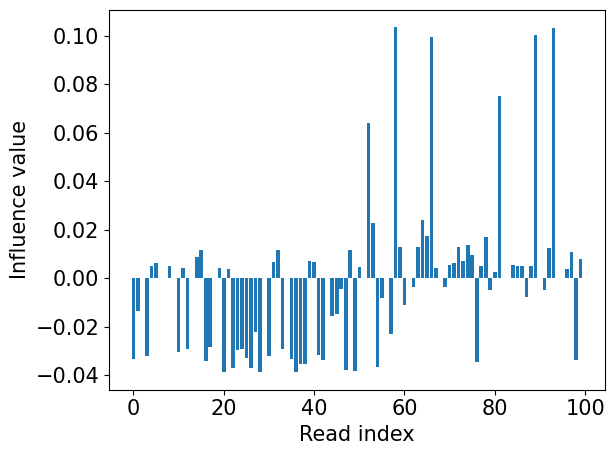

In [12]:
plt.bar([i for i in range(100)],shaps_10000_dataset_1[1][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_1_shap_neanderthals.png", bbox_inches='tight')


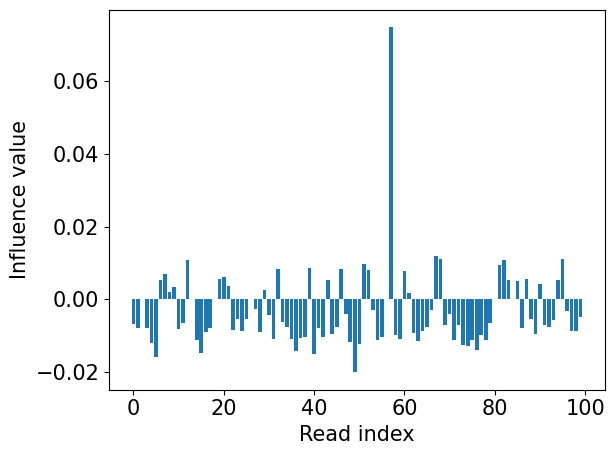

In [14]:
plt.bar([i for i in range(100)],shaps_10000_dataset_1[2][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_1_shap_denisovans.png", bbox_inches='tight')


And now we will show the counter factuals:

In [16]:
cf = maximum_likelihood_calculator_d_1.generateCounterFactualMinimalSetToRemoveAndChangeMax(shaps_10000_dataset_1)
print(sorted(cf[0]))


Change dominating species from Homo Sapiens to Neanderthal would require removing 20 reads: [49, 36, 76, 54, 28, 37, 38, 22, 35, 42, 16, 47, 98, 3, 0, 41, 24, 25, 10, 17]
[0, 3, 10, 16, 17, 22, 24, 25, 28, 35, 36, 37, 38, 41, 42, 47, 49, 54, 76, 98]


## Now we will look into the REAL -2

In [17]:
reads_2 = getListOfReadsFromBamFile(bamFilePath_2)
sorted_reads_2 = sorted(reads_2, key=lambda a: a["name"], reverse=True)
sorted_reads_only_sequence_2 = [a["read"] for a in sorted_reads_2]

[E::idx_find_and_load] Could not retrieve index file for 'data/RealData/merged_NeaDenisovaCave_Fumane_50_50_100reads.bam'


In [18]:
maximum_likelihood_calculator_d_2 = ExplainableMaximumLikelihoodCalculator(sorted_reads_only_sequence_2,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  100
start working on read number 0
start working on read number 40
start working on read number 80


In [19]:
maximum_likelihood_calculator_d_2.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.625,0.375,0.0


In [20]:
shaps_10000_second_dataset = maximum_likelihood_calculator_d_2.calculate_shapley_values(10000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10000


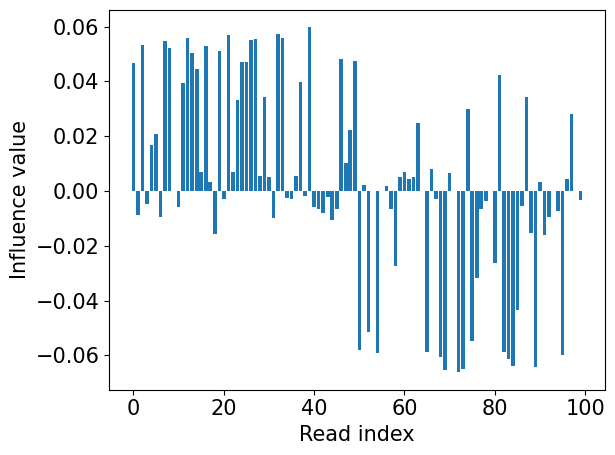

In [21]:
plt.bar([i for i in range(100)],shaps_10000_second_dataset[0][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()

plt.savefig("dataset_2_shap_homosapien.png", bbox_inches='tight')


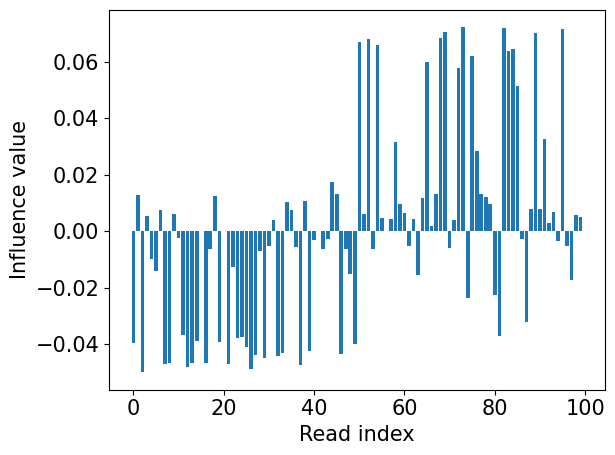

In [22]:
plt.bar([i for i in range(100)],shaps_10000_second_dataset[1][0])
plt.rcParams.update({'font.size': 15})
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()

plt.savefig("dataset_2_shap_neanderthals.png", bbox_inches='tight')


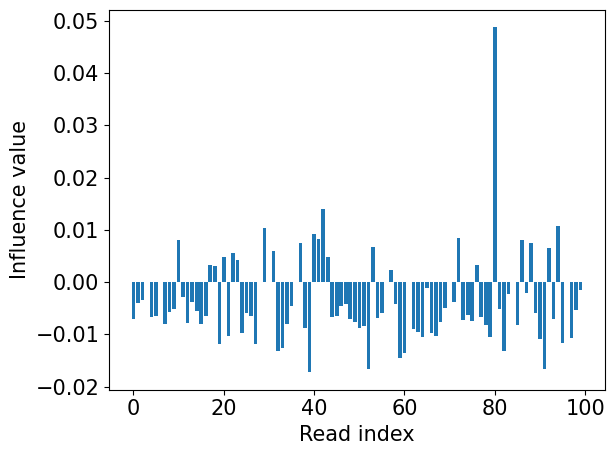

In [23]:
plt.bar([i for i in range(100)],shaps_10000_second_dataset[2][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_2_shap_denisovans.png", bbox_inches='tight')


In [24]:
cf = maximum_likelihood_calculator_d_2.generateCounterFactualMinimalSetToRemoveAndChangeMax(shaps_10000_second_dataset)
print(sorted(cf[0]))


Change dominating species from Homo Sapiens to Neanderthal would require removing 10 reads: [39, 32, 21, 12, 33, 27, 26, 7, 2, 16]
[2, 7, 12, 16, 21, 26, 27, 32, 33, 39]


## Now we will focus only on the Homo Sapiens library

In [25]:
maximum_likelihood_calculator_d_3 = ExplainableMaximumLikelihoodCalculator(sorted_reads_only_sequence_1[:50],
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  50
start working on read number 0
start working on read number 40


In [26]:
maximum_likelihood_calculator_d_3.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,1.0,0.0,0.0


## Now we will focus on the Neanderthals from the REAL 1

In [27]:
maximum_likelihood_calculator_d_4 = ExplainableMaximumLikelihoodCalculator(sorted_reads_only_sequence_1[50:],
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  50
start working on read number 0
start working on read number 40


In [28]:
maximum_likelihood_calculator_d_4.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.275,0.675,0.05


### Calculate SHAP estimation

In [29]:
shaps_10000_fourth_dataset = maximum_likelihood_calculator_d_4.calculate_shapley_values(10000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10000


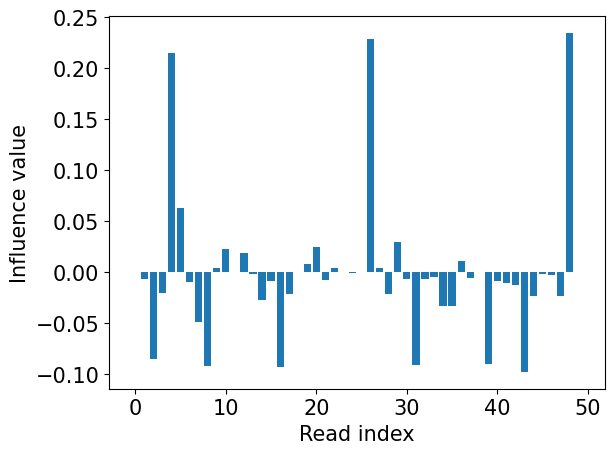

In [33]:
plt.bar([i for i in range(50)],shaps_10000_fourth_dataset[0][0])
plt.rcParams.update({'font.size': 15})
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_4_shap_homosapien.png", bbox_inches='tight')


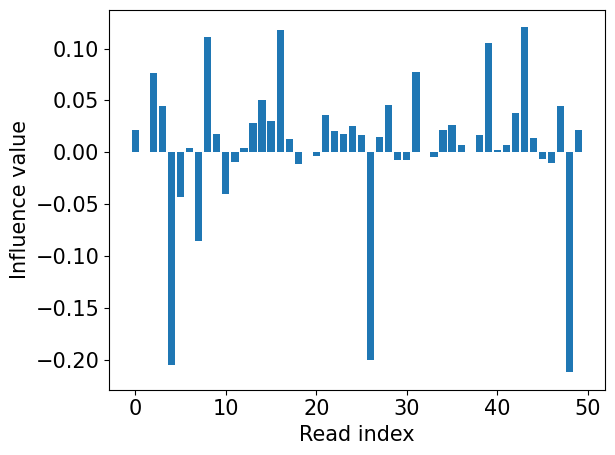

In [34]:
plt.bar([i for i in range(50)],shaps_10000_fourth_dataset[1][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_4_shap_neanderthals.png", bbox_inches='tight')

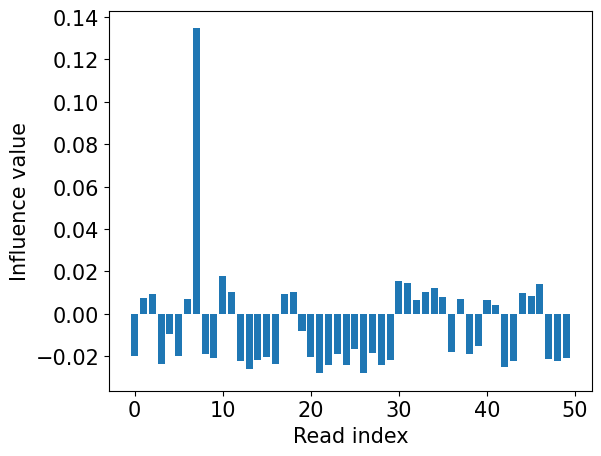

In [35]:
plt.bar([i for i in range(50)],shaps_10000_fourth_dataset[2][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_4_shap_denisovans.png", bbox_inches='tight')


In [36]:
outliers = sorted(list(enumerate(shaps_10000_fourth_dataset[0][0])), key=lambda a: a[1], reverse=True)[:3]
outliers

[(48, 0.2344800154720036), (26, 0.22869196235849681), (4, 0.2143206214776488)]

### Show alignments of each of the outlier sequences 

In [39]:
outlier_indexes = sorted([i[0] for i in outliers])
for ind in outlier_indexes:
    print(maximum_likelihood_calculator_d_4.plot_alignments_of_read(ind))

Printing all alignments for read number 4:
Read length is 32:
Alignments to Homo sapiens references:
Homo Sapiens-AF346981.1
101 ACCACCATCCTCCGTGAAATCAATATCCCGCA
    ||||||||||||||||||||||||||||||||
  1 ACCACCATCCTCCGTGAAATCAATATCCCGCA
  Score=32

Homo Sapiens-AY195760.2
98 ACCACCATCCTCCGTGAAATCAATATCCCGCA
   ||||||||||||||||||||||||||||||||
 1 ACCACCATCCTCCGTGAAATCAATATCCCGCA
  Score=32

Homo Sapiens-AY882416.1
99 ACCACCATCCTCCGTGAAATCAATATCCCGCA
   ||||||||||||||||||||||||||||||||
 1 ACCACCATCCTCCGTGAAATCAATATCCCGCA
  Score=32

Homo Sapiens-AY963586.3
110 ACCACCATCCTCCGTGAAATCAATATCCCGCA
    ||||||||||||||||||||||||||||||||
  1 ACCACCATCCTCCGTGAAATCAATATCCCGCA
  Score=32

Homo Sapiens-AY195781.2
99 ACCACCATCCTCCGTGAAATCAATATCCCGCA
   ||||||||||||||||||||||||||||||||
 1 ACCACCATCCTCCGTGAAATCAATATCCCGCA
  Score=32

Homo Sapiens-AY195757.1
101 ACCACCATCCTCCGTGAAATCAATATCCCGCA
    ||||||||||||||||||||||||||||||||
  1 ACCACCATCCTCCGTGAAATCAATATCCCGCA
  Score=32

Homo Sapiens-AY195749.2
95

### Analytize the dataset without the outliers

In [48]:
len(sample_without_outliers)

48

In [49]:
sample_without_outliers = sorted_reads_only_sequence_1[50:]
sample_without_outliers = [sample_without_outliers[i] for i in range(len(sample_without_outliers)) if i not in outlier_indexes]

In [51]:
maximum_likelihood_calculator_d_4_without_outliers = ExplainableMaximumLikelihoodCalculator(sample_without_outliers,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  47
start working on read number 0
start working on read number 40


In [53]:
maximum_likelihood_calculator_d_4_without_outliers.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.0,0.95,0.05


### Now analyze where would the outliers be using SHAP with less samples:

In [54]:
shaps_100_fourth_dataset = maximum_likelihood_calculator_d_4.calculate_shapley_values(100)
shaps_1000_fourth_dataset = maximum_likelihood_calculator_d_4.calculate_shapley_values(1000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000


In [57]:
outlier_indexes

[4, 26, 48]

In [55]:
sorted(list(enumerate(shaps_100_fourth_dataset[0][0])), key=lambda a: a[1], reverse=True)[:5]

[(26, 0.3758961108405947),
 (5, 0.30481538136126285),
 (48, 0.18072921018914367),
 (4, 0.18057354909316042),
 (13, 0.15968410815311374)]

In [56]:
sorted(list(enumerate(shaps_1000_fourth_dataset[0][0])), key=lambda a: a[1], reverse=True)[:5]

[(48, 0.23926584667362932),
 (4, 0.23690412595496352),
 (26, 0.23484670611684585),
 (5, 0.07314362128600488),
 (20, 0.039605658058579886)]

## Now only the Neanderthals from REAL-2

In [58]:
only_cave_neanderthals_sample = sorted_reads_only_sequence_2[:50]

In [59]:
maximum_likelihood_calculator_real_2_only_cave_nean = ExplainableMaximumLikelihoodCalculator(only_cave_neanderthals_sample,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  50
start working on read number 0
start working on read number 40


In [60]:
maximum_likelihood_calculator_real_2_only_cave_nean.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,1.0,0.0,0.0


In [61]:
shaps_10000_only_nean_cave =  maximum_likelihood_calculator_real_2_only_cave_nean.calculate_shapley_values(10000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10000


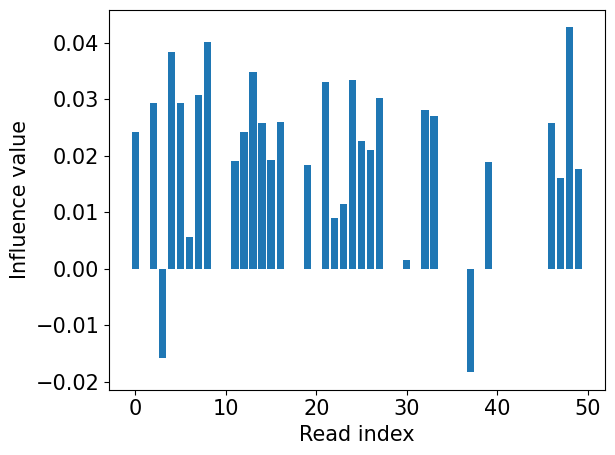

In [62]:
plt.bar([i for i in range(50)],shaps_10000_only_nean_cave[0][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_4_shap_homosapien.png", bbox_inches='tight')


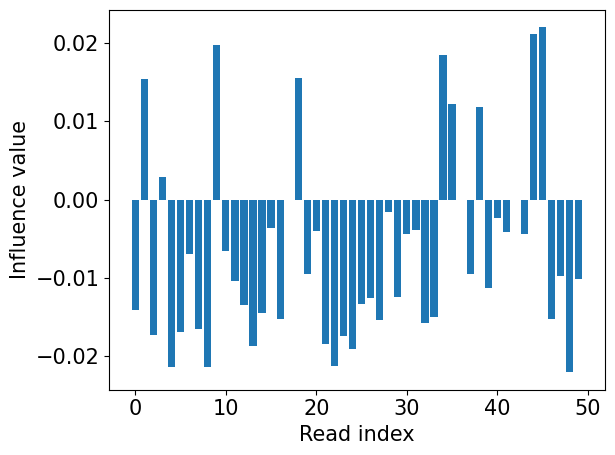

In [63]:
plt.bar([i for i in range(50)],shaps_10000_only_nean_cave[1][0])
plt.rcParams.update({'font.size': 15})

plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.tight_layout()
plt.savefig("dataset_only_cave_nean_shap_neanderthals.png", bbox_inches='tight')